# Calibration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
'000260'
'000333'
'1586'
'400'
'data file numerations are like [20:1586:5]'
data_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000333/data_000000.txt"
half_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000333/data_"
data_paths=[half_path+str(i).zfill(6)+'.txt' for i in range(20,400,5)]

#best detectors configuration for a given run ([2,3] or [0,1]?)
calib_config=[0,1,2,3]

In [3]:
cal1={}
false_events_counter=0
for data_path in data_paths:
    with open(data_path) as data_file:
        for line in data_file:
            row=line.strip().split()
            key=int(row[0])
            n_hits=int(row[1])
            if n_hits!=0:
                data_array=np.array(row[2:]).reshape((n_hits, 5))
                data_dict={}
                columns=['chamber', 'layer', 'xleft', 'xright', 'time']
                for i in range(2):
                    data_dict[columns[i]]=data_array[:, i].astype(int)
                for i in range(2,5):
                    data_dict[columns[i]]=data_array[:, i].astype(float)
                value=pd.DataFrame(data_dict)
                cal1[key]=value
            else:
                false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f'original data length: {original_data_length}')
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

original data length: 14444
null over nonnull events ratio (%) : 24.141512046524507%


In [4]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)
    event['center']=(event['xlg']+event['xrg'])/2
    event['valid_hit']=pd.Series(np.ones(len(event)).astype(bool))

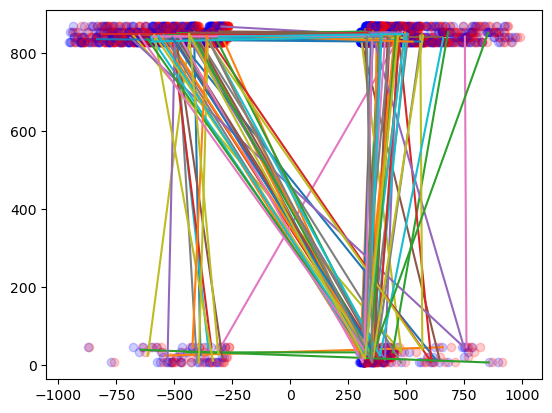

In [5]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

[(2946, '[0, 2]'), (1981, '[0, 1, 2]'), (1575, '[0]'), (1395, '[2]'), (587, '[0, 1, 2, 3]'), (574, '[0, 1]'), (396, '[1, 2]'), (346, '[1]'), (340, '[0, 2, 3]'), (281, '[2, 3]'), (214, '[3]'), (115, '[0, 3]'), (92, '[1, 2, 3]'), (77, '[0, 1, 3]'), (38, '[1, 3]')]
('[0, 2]', '[0, 1, 2]', '[0]', '[2]', '[0, 1, 2, 3]', '[0, 1]', '[1, 2]', '[1]', '[0, 2, 3]', '[2, 3]', '[3]', '[0, 3]', '[1, 2, 3]', '[0, 1, 3]', '[1, 3]') (2946, 1981, 1575, 1395, 587, 574, 396, 346, 340, 281, 214, 115, 92, 77, 38)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

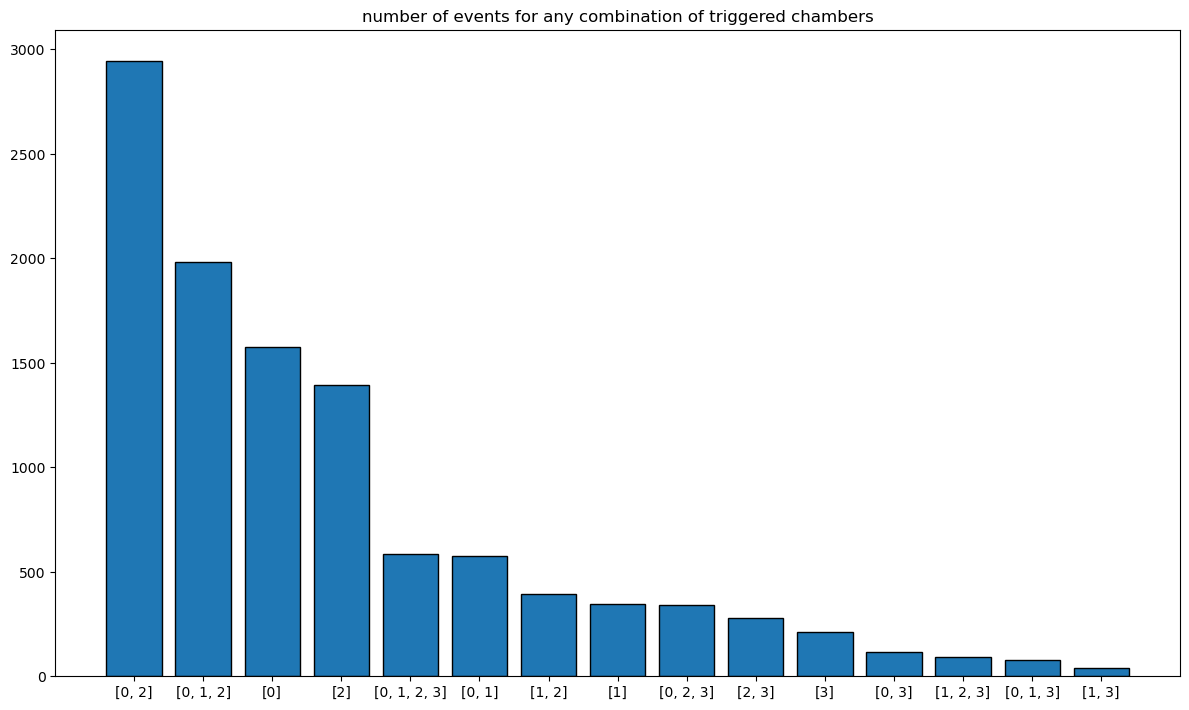

In [6]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

average n_hits per event: 35.39863713798978
 most frequent n_hits per event 14



Text(0.5, 1.0, 'number of events vs number of hits for the [0, 1, 2, 3] chambers events')

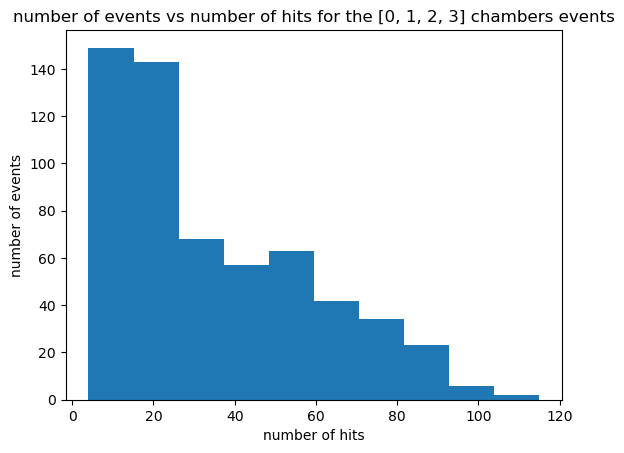

In [7]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(f'average n_hits per event: {np.mean(n_hits_per_event)}')
print(f' most frequent n_hits per event {np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])]}')
#plt.hist(n_hits_per_event, bins=33)
plt.hist(n_hits_per_event)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title(f'number of events vs number of hits for the {calib_config} chambers events')

In [8]:
'''
print(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))
print(cal1[4])
'''

"\nprint(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))\nprint(cal1[4])\n"

In [9]:
print(list((np.abs(event['xleft']-event['xright'])>XCELL).index))
print(cal1[1].index)

[0, 1, 2, 3, 4, 5, 6]
RangeIndex(start=0, stop=18, step=1)


In [10]:
#filters for event selection

def desired_chamber_config(event):
    return sorted(np.unique(event['chamber']))==calib_config

def three_layers_per_det(event):
    return not np.any(event[event['valid_hit']==True].groupby('chamber')['layer'].nunique().reset_index()['layer']<3)

def one_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']!=1)


#filters for (bad) hit selection

def coordinates_outside_cell(event):
    return list((np.abs(event['xleft']-event['xright'])>XCELL).index)

def deviant_hit(event): 
    n_sigmas_treshhold=2
    bad_indices=[]
    def other_hits_mu_std(out_index, event):
        index=list(event.index)
        index.remove(out_index)
        return event.loc[index]['center'].mean(), event.loc[index]['center'].std() 
        
    for index, row in event.iterrows():
        mu, std=other_hits_mu_std(index, event)
        if abs(row['center']-mu)/std > n_sigmas_treshhold:
            bad_indices.append(index)
    return bad_indices

#filter applicators:

def event_filter(keys_list, e_filter): #modifies the list of keys
    return list(filter(lambda key : e_filter(cal1[key]), keys_list))

def hit_filter(keys_list, h_filter): #modifies in place the 'valid_hit' column of dataset
    for key in keys_list:
        event=cal1[key]
        #the "bad" filters return lists of "bad" hit indices, to be set to false. So the lists can just be concatenate with "+"
        bad_rows_indices_list=h_filter(event)
        #print('before:', event)
        event.loc[bad_rows_indices_list,'valid_hit'] = False
        #print('after:', event)

#FILTERS APPLICATION (both event_filters and hit_filters):
#NB: THE ORDER MATTERS!
impeccable_events=event_filter(cal1, desired_chamber_config)
impeccable_events=event_filter(impeccable_events, one_hit_per_layer)
#hit_filter(impeccable_events, coordinates_outside_cell)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, deviant_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
impeccable_events=event_filter(impeccable_events, three_layers_per_det)

print(impeccable_events)
print(len(impeccable_events))
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")

ratio between impeccable events and nonzerohit events 0.004472027014693803
 ratio between impeccable events and original dataset events 0.003392412074217668
ratio between impeccable events and nonzerohit events 0.004472027014693803
 ratio between impeccable events and original dataset events 0.003392412074217668
[13, 1906, 4830, 4944, 4980, 5299, 5893, 6865, 8454, 9977, 10053, 10246, 13538, 14367]
14
ratio between impeccable events and nonzerohit events 0.0012777220041982295
 ratio between impeccable events and original dataset events 0.0009692605926336195


In [11]:
print(cal1[4944])
hit_filter([4944], deviant_hit)
#event_plotter(2)
print(deviant_hit(cal1[4944]))

    chamber  layer  xleft  xright   time    xrg    xlg    zg  center  \
0         1      1  254.7   291.3  340.5  692.7  656.1  45.5   674.4   
1         3      4  250.6   253.4   26.4 -512.1 -514.9   6.5  -513.5   
2         3      2  206.7   213.3   62.2 -468.2 -474.8  32.5  -471.5   
3         3      2  291.4   296.6   48.0 -552.9 -558.1  32.5  -555.5   
4         3      4  208.7   211.3   23.9 -470.2 -472.8   6.5  -471.5   
5         3      3  257.9   288.1  279.7 -519.4 -549.6  19.5  -534.5   
6         3      4  286.3   301.7  143.0 -547.8 -563.2   6.5  -555.5   
7         3      1  379.8   418.2  356.4 -641.3 -679.7  45.5  -660.5   
8         3      1  173.3   204.7  291.4 -434.8 -466.2  45.5  -450.5   
9         3      1  296.9   333.1  335.5 -558.4 -594.6  45.5  -576.5   
10        3      3  170.1   207.9  351.4 -431.6 -469.4  19.5  -450.5   
11        3      4  273.9   314.1  373.0 -535.4 -575.6   6.5  -555.5   

    valid_hit  
0        True  
1        True  
2        True  

In [17]:
print(cal1[4944].groupby('chamber')['layer'].nunique().reset_index())
print(cal1[4944])

   chamber  layer
0        0      3
1        1      4
2        2      4
3        3      4
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  603.70  614.30   98.8  390.50  379.90  869.0  385.200   
1         0      3  601.90  616.10  131.3  392.30  378.10  843.0  385.200   
2         0      4  616.30  643.70  253.8  377.90  350.50  830.0  364.200   
3         1      1  607.90  610.10   21.3  339.50  337.30   45.5  338.400   
4         1      3  607.60  610.40   26.3  339.80  337.00   19.5  338.400   
5         1      2  610.10  649.90  368.8  337.30  297.50   32.5  317.400   
6         1      4  611.50  648.50  343.8  335.90  298.90    6.5  317.400   
7         2      3  100.30  109.70   88.0 -367.70 -377.10  843.0 -372.400   
8         2      2   75.49   92.51  158.0 -342.89 -359.91  856.0 -351.400   
9         2      4   69.21   98.79  274.6 -336.61 -366.19  830.0 -351.400   
10        2      1  425.10  456.90  295.5 -692.50 -724.30  869.

In [13]:
from itertools import product
from scipy.stats import pearsonr
from math import atan2


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        return angle(B,C)-angle(A,B)

def zigzaginess(path):
    if(len(path)>=3):
        squaresum=0
        for i in range(len(path)-2):
            A=path[i]
            B=path[i+1]
            C=path[i+2]
            squaresum+=(angle(A,B,C))**2
        return squaresum
    else:
        print("Error: path of less than 3 points")
        return "error"

def opt_track(event, chamber):
    single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]
    single_chamber=single_chamber.sort_values(by='zg')
    axes=[['xrg', 'xlg']]*len(single_chamber)
    xcs=list(product(*axes))
    paths=[[(np.array(single_chamber[xc[i]])[i], np.array(single_chamber['zg'])[i] ) for i in range(len(single_chamber))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    straightness_function=lambda x: -zigzaginess(x)
    best_path=max(paths, key=straightness_function)
    return best_path

0
13
    chamber  layer   xleft  xright   time     xrg    xlg     zg  center  \
0         0      2  624.70   635.3   98.8  369.50  358.9  856.0  364.20   
1         0      4  623.40   636.6  123.0  370.80  357.6  830.0  364.20   
2         0      1  634.00   668.0  315.5  360.20  326.2  869.0  343.20   
3         1      2  628.00   632.0   38.0  319.40  315.4   32.5  317.40   
4         1      4  628.80   631.2   23.0  318.60  316.2    6.5  317.40   
5         1      1  591.30   626.7  329.6  356.10  320.7   45.5  338.40   
6         1      3  590.20   627.8  349.6  357.20  319.6   19.5  338.40   
7         2      1  145.40   148.6   28.8 -412.80 -416.0  869.0 -414.40   
8         2      3  144.30   149.7   49.6 -411.70 -417.1  843.0 -414.40   
9         2      2  106.90   145.1  355.5 -374.30 -412.5  856.0 -393.40   
10        3      3  100.30   109.7   88.0 -361.80 -371.2   19.5 -366.50   
11        3      1   98.92   111.1  113.0 -360.42 -372.6   45.5 -366.51   
12        3      2  

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


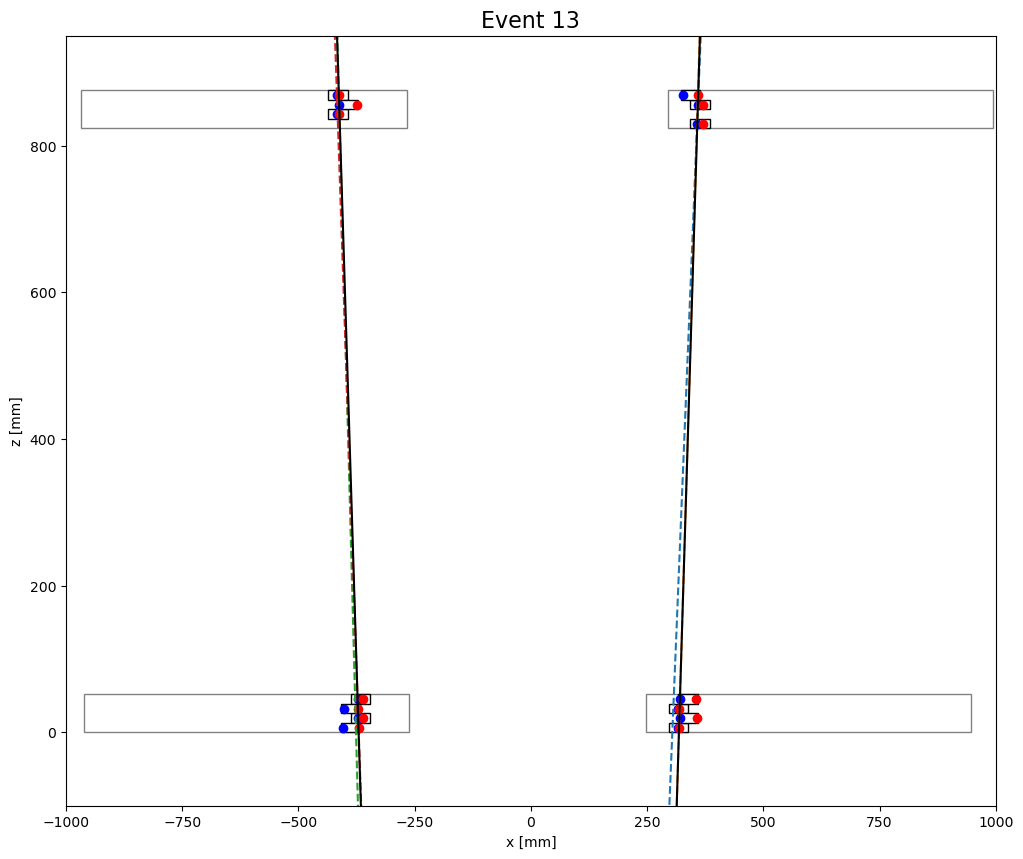

1
1906
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  557.10  576.90  183.9  437.10  417.30  869.0   427.2   
1         0      3  554.10  579.90  238.9  440.10  414.30  843.0   427.2   
2         0      4  580.20  595.80  144.7  414.00  398.40  830.0   406.2   
3         1      4  583.80  592.20   77.2  363.60  355.20    6.5   359.4   
4         1      2  581.80  594.20  115.5  365.60  353.20   32.5   359.4   
5         1      1  553.50  580.50  250.5  393.90  366.90   45.5   380.4   
6         1      3  551.70  582.30  283.9  395.70  365.10   19.5   380.4   
7         2      1   56.20   69.80  126.4 -323.60 -337.20  869.0  -330.4   
8         2      3   55.39   70.61  141.4 -322.79 -338.01  843.0  -330.4   
9         2      2   27.88   56.12  262.2 -295.28 -323.52  856.0  -309.4   
10        2      4   28.96   55.04  242.2 -296.36 -322.44  830.0  -309.4   
11        3      1   15.41   26.59  103.9 -276.91 -288.09   45.5  -282.5   
12   

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


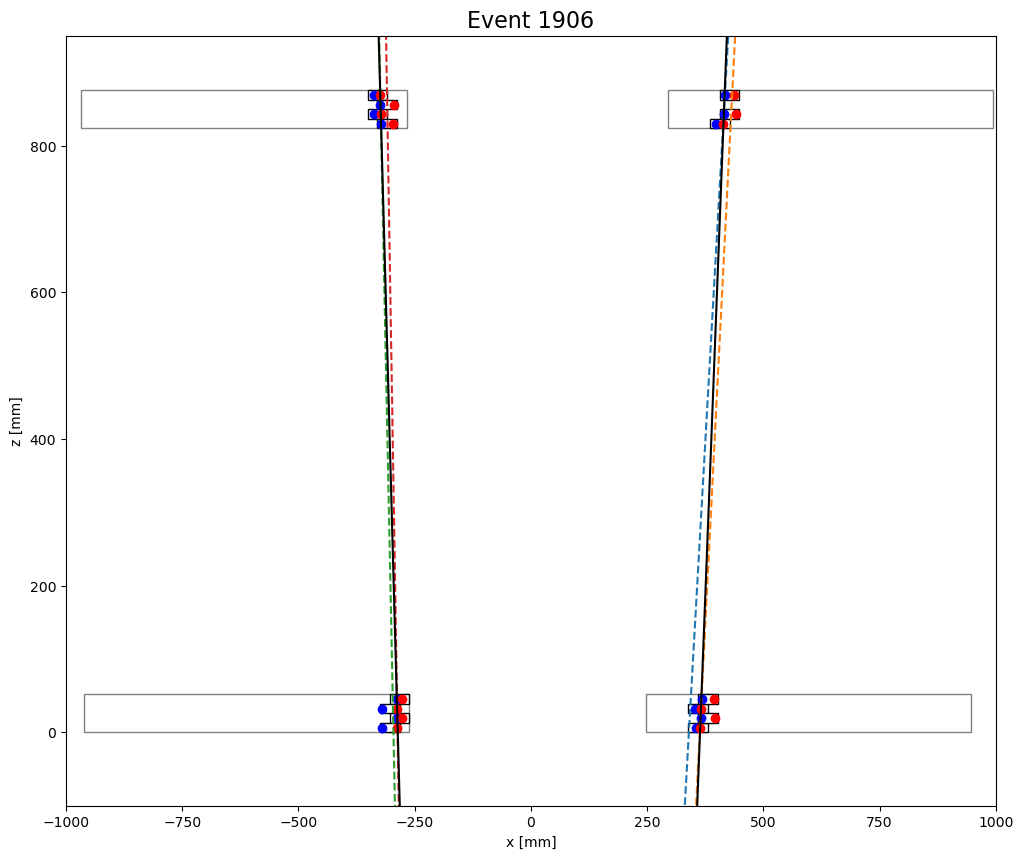

2
4830
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      3  604.10  613.90   90.5  390.10  380.30  843.0   385.2   
1         0      1  602.60  615.40  118.0  391.60  378.80  869.0   385.2   
2         0      4  569.80  606.20  338.8  424.40  388.00  830.0   406.2   
3         1      2  578.10  597.90  183.0  369.30  349.50   32.5   359.4   
4         1      1  595.70  622.30  247.1  351.70  325.10   45.5   338.4   
5         1      4  577.40  598.60  196.3  370.00  348.80    6.5   359.4   
6         1      3  597.40  620.60  216.3  350.00  326.80   19.5   338.4   
7         2      1   62.57   63.43    8.0 -329.97 -330.83  869.0  -330.4   
8         2      3   61.58   64.42   26.3 -328.98 -331.82  843.0  -330.4   
9         2      4   22.54   61.46  361.3 -289.94 -328.86  830.0  -309.4   
10        3      1   10.16   31.84  201.3 -271.66 -293.34   45.5  -282.5   
11        3      2   31.47   52.53  195.5 -292.97 -314.03   32.5  -303.5   
12   

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


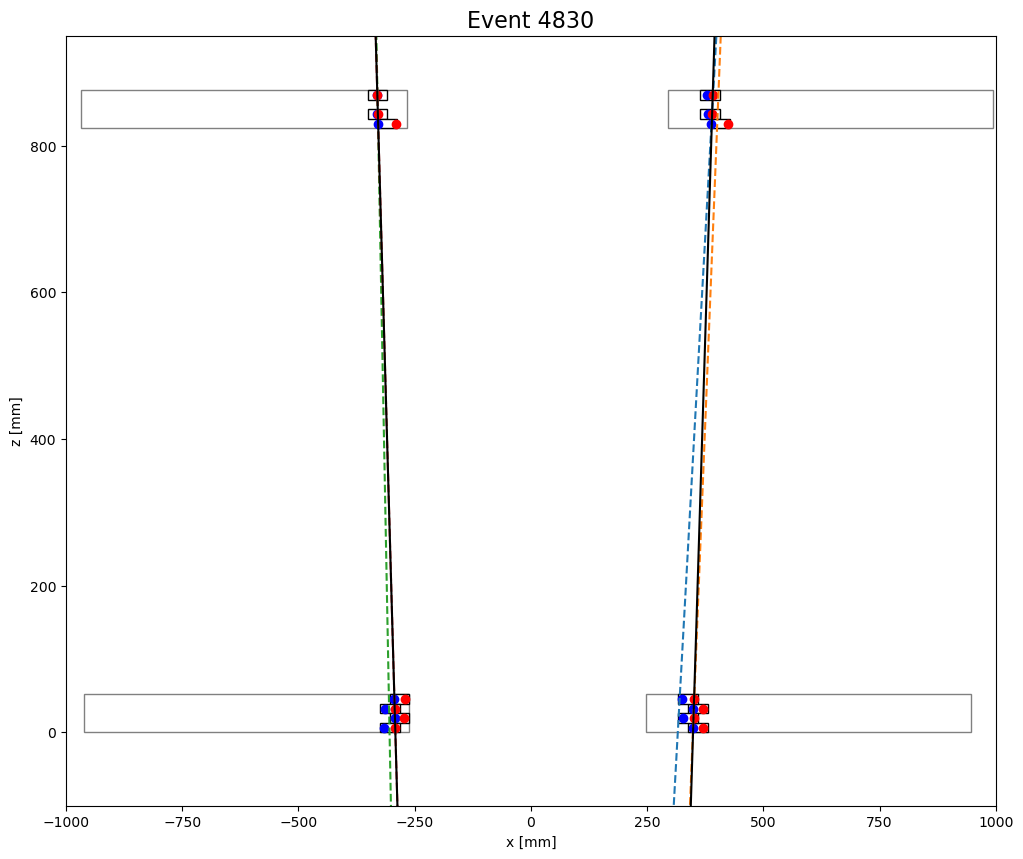

3
4944
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  603.70  614.30   98.8  390.50  379.90  869.0  385.200   
1         0      3  601.90  616.10  131.3  392.30  378.10  843.0  385.200   
2         0      4  616.30  643.70  253.8  377.90  350.50  830.0  364.200   
3         1      1  607.90  610.10   21.3  339.50  337.30   45.5  338.400   
4         1      3  607.60  610.40   26.3  339.80  337.00   19.5  338.400   
5         1      2  610.10  649.90  368.8  337.30  297.50   32.5  317.400   
6         1      4  611.50  648.50  343.8  335.90  298.90    6.5  317.400   
7         2      3  100.30  109.70   88.0 -367.70 -377.10  843.0 -372.400   
8         2      2   75.49   92.51  158.0 -342.89 -359.91  856.0 -351.400   
9         2      4   69.21   98.79  274.6 -336.61 -366.19  830.0 -351.400   
10        2      1  425.10  456.90  295.5 -692.50 -724.30  869.0 -708.400   
11        3      3   60.46   65.54   47.1 -321.96 -327.04   19.5 -324

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


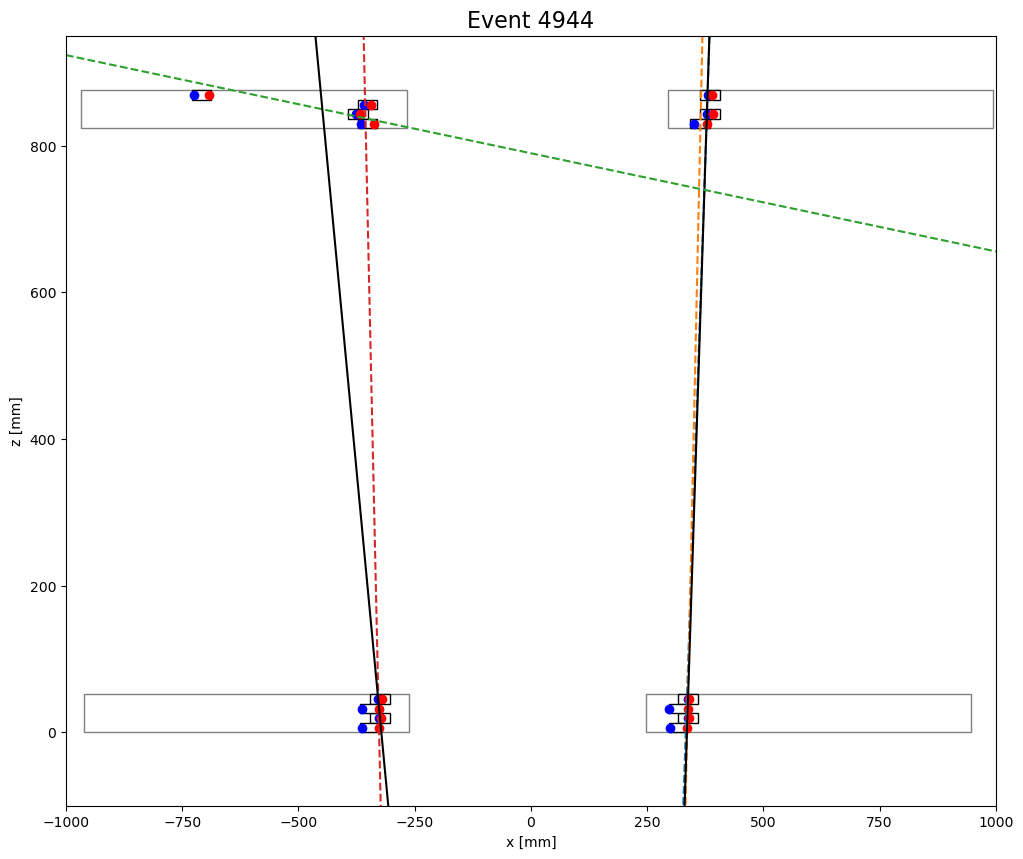

4
4980
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      1  558.200  575.80  163.0  436.000  418.40  869.0  427.2000   
1         0      4  578.900  597.10  169.6  415.300  397.10  830.0  406.2000   
2         0      3  556.300  577.70  198.0  437.900  416.50  843.0  427.2000   
3         1      4  581.000  595.00  129.6  366.400  352.40    6.5  359.4000   
4         1      1  556.000  578.00  204.6  391.400  369.40   45.5  380.4000   
5         1      2  579.900  596.10  151.3  367.500  351.30   32.5  359.4000   
6         1      3  553.500  580.50  251.3  393.900  366.90   19.5  380.4000   
7         2      3   58.310   67.69   87.1 -325.710 -335.09  843.0 -330.4000   
8         2      1   59.160   66.84   71.3 -326.560 -334.24  869.0 -330.4000   
9         2      2   25.640   58.36  303.8 -293.040 -325.76  856.0 -309.4000   
10        2      4   26.310   57.69  291.3 -293.710 -325.09  830.0 -309.4000   
11        3      2   39.330   44.

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


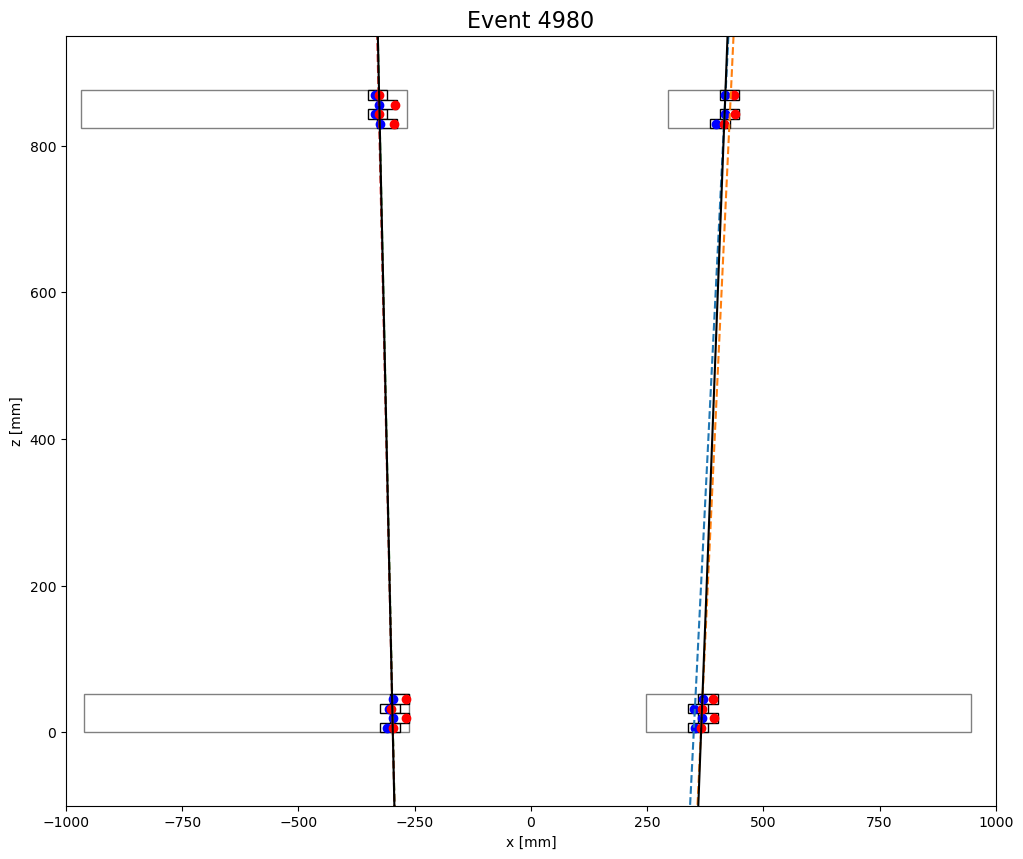

5
5299
    chamber  layer   xleft  xright   time     xrg    xlg     zg   center  \
0         0      1  102.10   107.9   54.7  892.10  886.3  869.0  889.200   
1         0      3   98.69   111.3  117.2  895.51  882.9  843.0  889.205   
2         0      2  107.40   144.6  344.7  886.80  849.6  856.0  868.200   
3         1      3  356.20   357.8   15.5  591.20  589.6   19.5  590.400   
4         1      1  348.30   365.7  162.2  599.10  581.7   45.5  590.400   
5         1      2  319.00   353.0  315.5  628.40  594.4   32.5  611.400   
6         1      4  363.50   392.5  269.7  583.90  554.9    6.5  569.400   
7         2      3  270.30   275.7   49.7 -537.70 -543.1  843.0 -540.400   
8         2      1  265.90   280.1  131.3 -533.30 -547.5  869.0 -540.400   
9         2      2  278.40   309.6  290.5 -545.80 -577.0  856.0 -561.400   
10        2      4  274.30   313.7  366.3 -541.70 -581.1  830.0 -561.400   
11        3      1  142.90   151.1   75.5 -404.40 -412.6   45.5 -408.500   
12   

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


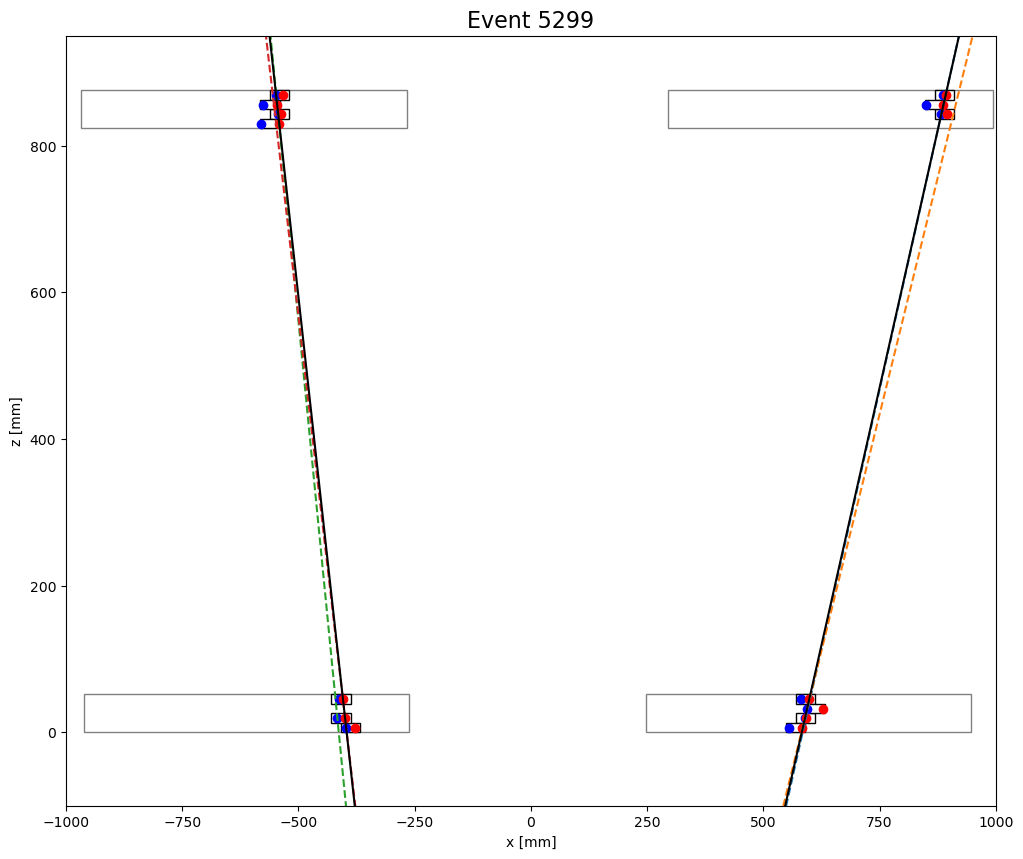

6
5893
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  626.30  633.70   68.0  367.90  360.50  856.0   364.2   
1         0      4  625.10  634.90   91.3  369.10  359.30  830.0   364.2   
2         0      1  632.40  669.60  344.7  361.80  324.60  869.0   343.2   
3         1      2  627.40  632.60   48.8  320.00  314.80   32.5   317.4   
4         1      4  628.30  631.70   32.2  319.10  315.70    6.5   317.4   
5         1      1  592.20  625.80  312.2  355.20  321.60   45.5   338.4   
6         1      3  590.90  627.10  335.5  356.50  320.30   19.5   338.4   
7         2      3  104.30  105.70   13.0 -371.70 -373.10  843.0  -372.4   
8         2      4   82.58   85.42   26.3 -349.98 -352.82  830.0  -351.4   
9         2      2  106.40  145.60  364.7 -373.80 -413.00  856.0  -393.4   
10        3      1   54.63   71.37  155.5 -316.13 -332.87   45.5  -324.5   
11        3      3   55.97   70.03  130.5 -317.47 -331.53   19.5  -324.5   
12   

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


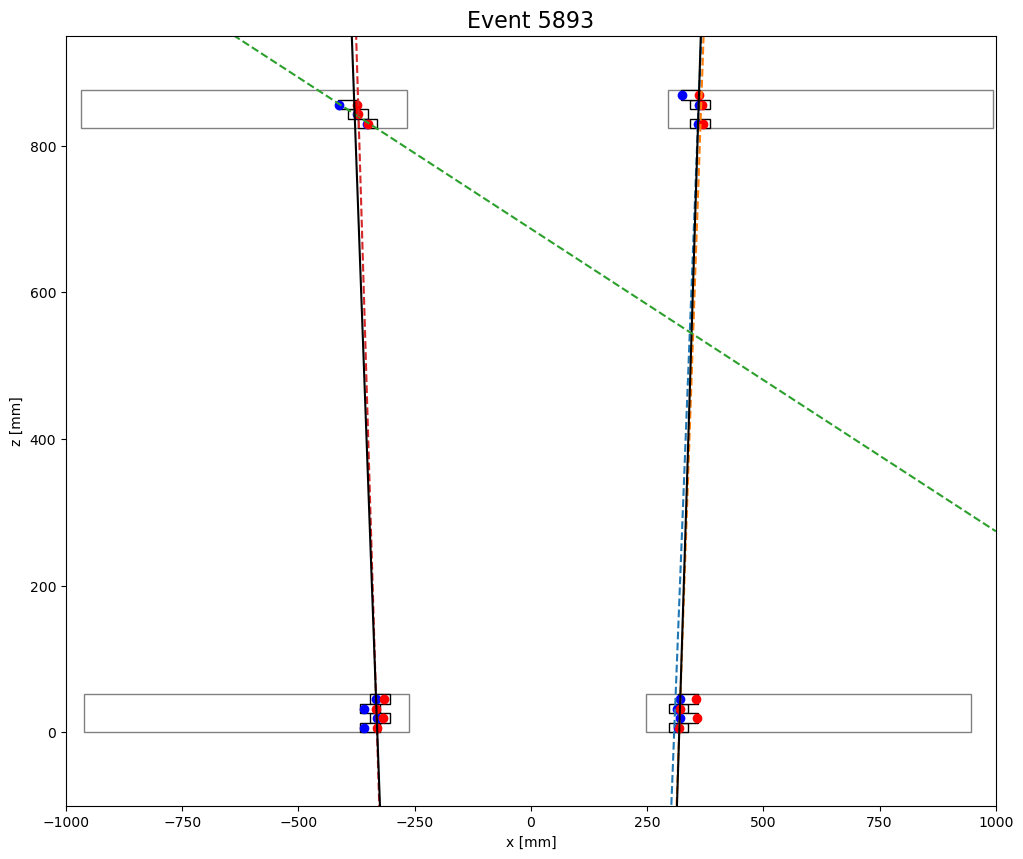

7
6865
    chamber  layer    xleft  xright   time      xrg     xlg     zg   center  \
0         0      2  625.900  634.10   75.5  368.300  360.10  856.0  364.200   
1         0      4  627.200  632.80   52.1  367.000  361.40  830.0  364.200   
2         0      1  592.600  625.40  304.6  401.600  368.80  869.0  385.200   
3         0      3  590.400  627.60  345.5  403.800  366.60  843.0  385.200   
4         1      1  600.400  617.60  158.8  347.000  329.80   45.5  338.400   
5         1      3  602.100  615.90  128.8  345.300  331.50   19.5  338.400   
6         1      2  618.200  641.80  219.6  329.200  305.60   32.5  317.400   
7         1      4  619.800  640.20  188.8  327.600  307.20    6.5  317.400   
8         2      1   59.430   66.57   66.3 -326.830 -333.97  869.0 -330.400   
9         2      3   59.430   66.57   66.3 -326.830 -333.97  843.0 -330.400   
10        2      2   24.200   59.80  330.5 -291.600 -327.20  856.0 -309.400   
11        2      4   25.060   58.94  314.6 -2

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


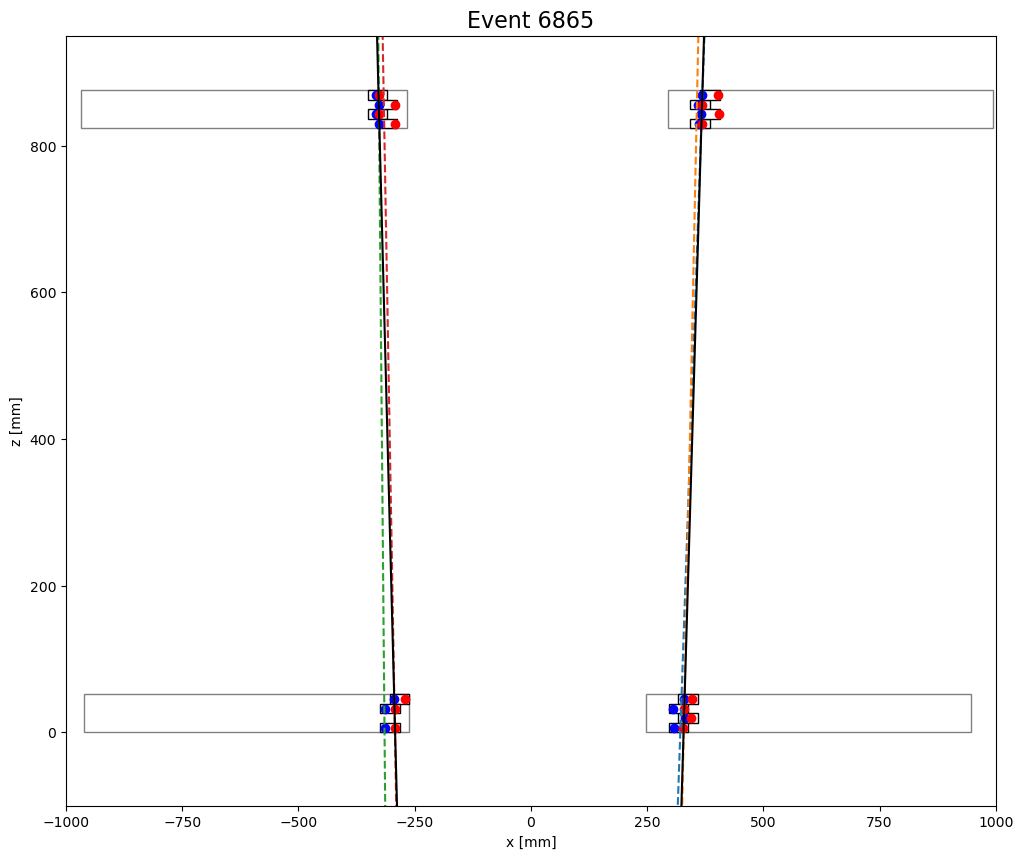

8
8454
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  597.10  620.90  221.4  397.10  373.30  869.0  385.20   
1         0      3  599.80  618.20  171.4  394.40  376.00  843.0  385.20   
2         0      4  575.50  600.50  233.0  418.70  393.70  830.0  406.20   
3         1      4  585.60  590.40   44.7  361.80  357.00    6.5  359.40   
4         1      2  580.70  595.30  135.5  366.70  352.10   32.5  359.40   
5         1      1  594.10  623.90  276.4  353.30  323.50   45.5  338.40   
6         1      3  595.90  622.10  243.0  351.50  325.30   19.5  338.40   
7         2      3   95.64  114.40  173.9 -363.04 -381.80  843.0 -372.42   
8         2      2  121.30  130.70   87.2 -388.70 -398.10  856.0 -393.40   
9         2      4  114.10  137.90  221.4 -381.50 -405.30  830.0 -393.40   
10        3      2   77.24   90.76  125.5 -338.74 -352.26   32.5 -345.50   
11        3      4   75.76   92.24  153.0 -337.26 -353.74    6.5 -345.50   
12   

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


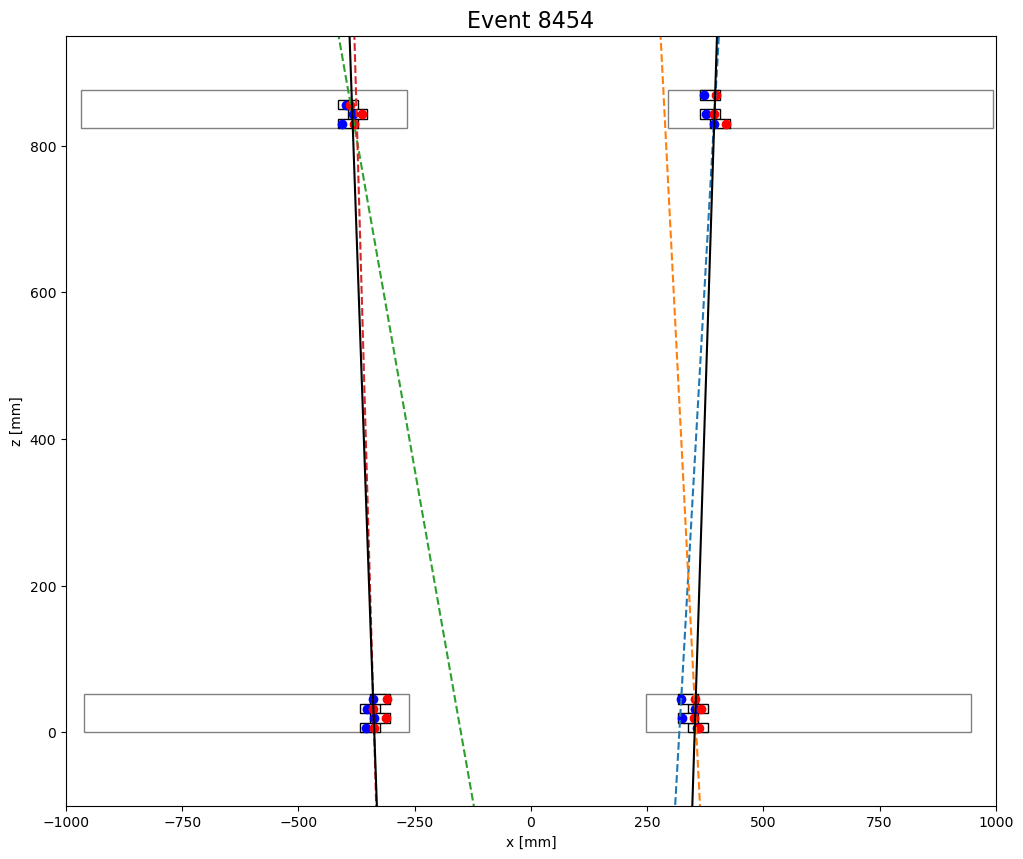

9
9977
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      2  621.90  638.10  149.7  372.30  356.10  856.0  364.200   
1         0      4  620.00  640.00  185.5  374.20  354.20  830.0  364.200   
2         0      1  637.30  664.70  253.8  356.90  329.50  869.0  343.200   
3         0      3  638.10  663.90  239.7  356.10  330.30  843.0  343.200   
4         1      2  625.10  634.90   90.5  322.30  312.50   32.5  317.400   
5         1      4  626.30  633.70   68.0  321.10  313.70    6.5  317.400   
6         1      1  594.30  623.70  272.2  353.10  323.70   45.5  338.400   
7         2      3   98.29  111.70  124.7 -365.69 -379.10  843.0 -372.395   
8         2      2   68.67   99.33  284.7 -336.07 -366.73  856.0 -351.400   
9         2      4   70.06   97.94  258.8 -337.46 -365.34  830.0 -351.400   
10        3      1   61.54   64.46   27.2 -323.04 -325.96   45.5 -324.500   
11        3      3   62.39   63.61   11.3 -323.89 -325.11   19.5 -324

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


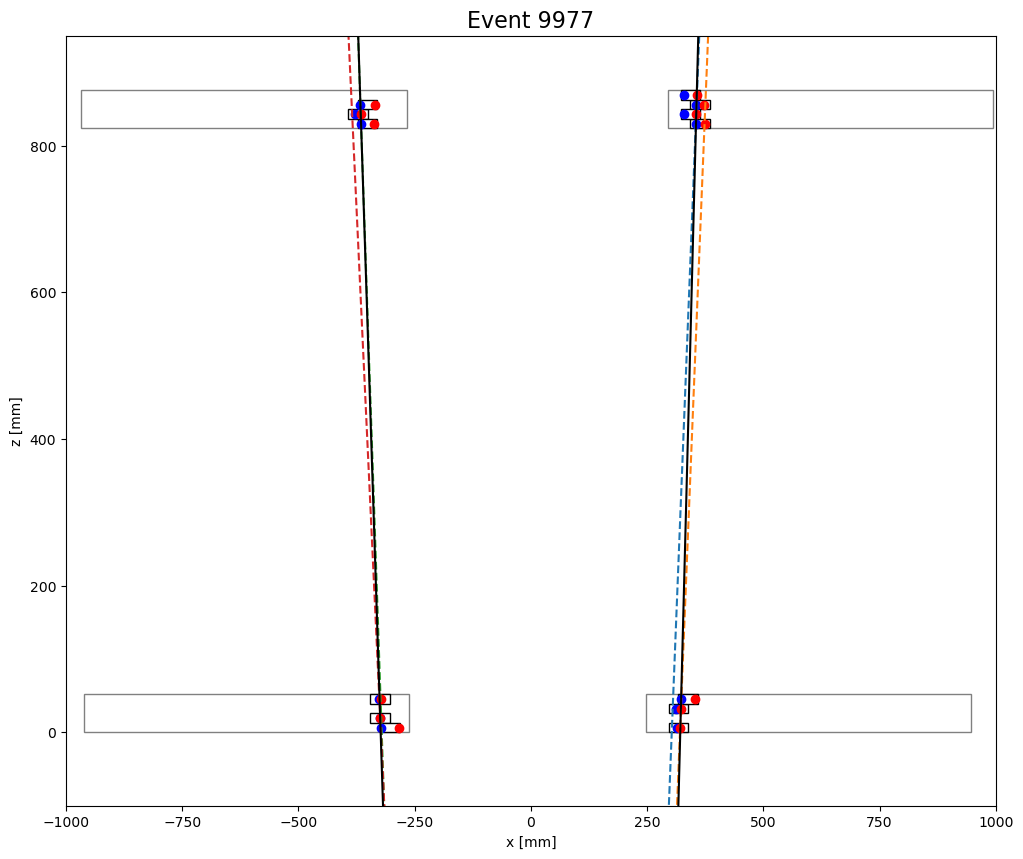

10
10053
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  602.70  615.30  116.4  391.50  378.90  869.0   385.2   
1         0      3  601.00  617.00  148.9  393.20  377.20  843.0   385.2   
2         0      2  615.30  644.70  273.9  378.90  349.50  856.0   364.2   
3         0      4  616.60  643.40  249.7  377.60  350.80  830.0   364.2   
4         1      1  606.60  611.40   44.7  340.80  336.00   45.5   338.4   
5         1      3  608.10  609.90   17.2  339.30  337.50   19.5   338.4   
6         1      4  610.20  649.80  367.2  337.20  297.60    6.5   317.4   
7         1      2  568.50  607.50  362.2  378.90  339.90   32.5   359.4   
8         2      2   75.58   92.42  156.4 -342.98 -359.82  856.0  -351.4   
9         2      1   50.18   75.82  238.0 -317.58 -343.22  869.0  -330.4   
10        2      4   74.50   93.50  176.4 -341.90 -360.90  830.0  -351.4   
11        3      4   41.07   42.93   17.2 -302.57 -304.43    6.5  -303.5   
12 

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


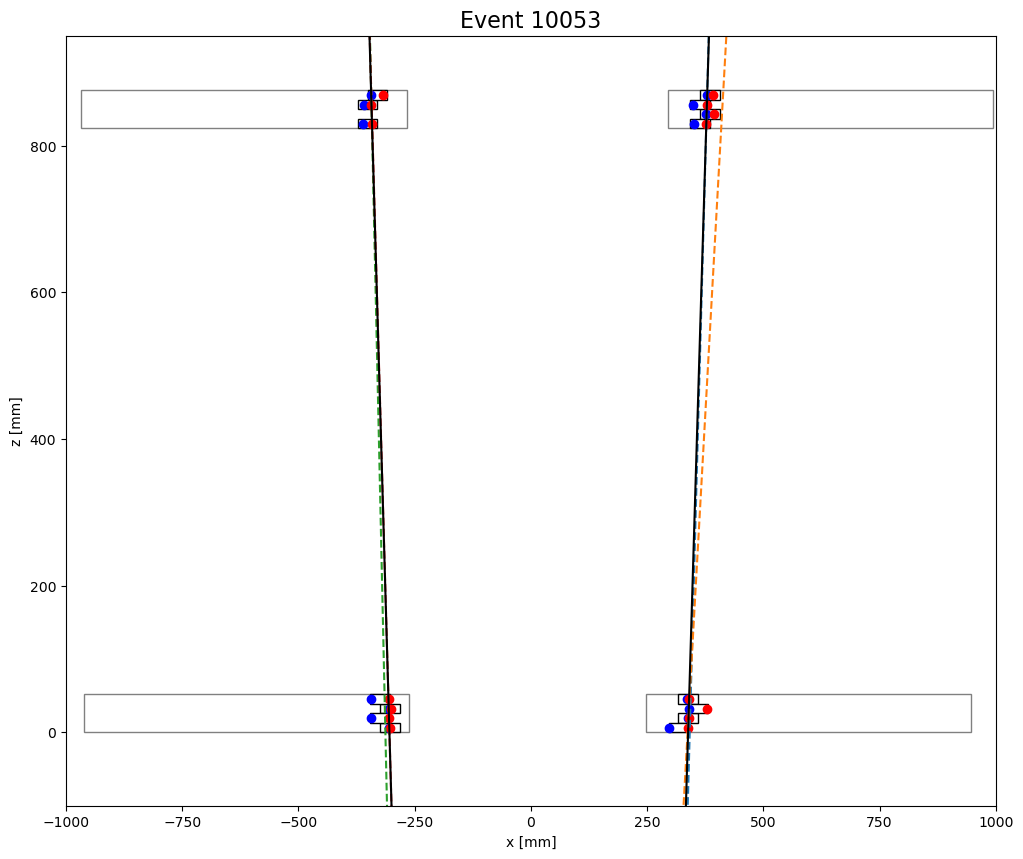

11
10246
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  599.50  618.50  175.5  394.70  375.70  869.0   385.2   
1         0      3  602.10  615.90  128.0  392.10  378.30  843.0   385.2   
2         0      4  573.20  602.80  274.7  421.00  391.40  830.0   406.2   
3         1      2  577.90  598.10  188.0  369.50  349.30   32.5   359.4   
4         1      1  595.90  622.10  243.0  351.50  325.30   45.5   338.4   
5         1      4  577.70  598.30  191.4  369.70  349.10    6.5   359.4   
6         1      3  597.10  620.90  221.4  350.30  326.50   19.5   338.4   
7         2      1   60.64   65.36   43.9 -328.04 -332.76  869.0  -330.4   
8         2      3   60.42   65.58   48.0 -327.82 -332.98  843.0  -330.4   
9         2      2   22.99   61.01  353.0 -290.39 -328.41  856.0  -309.4   
10        2      4   23.98   60.02  334.7 -291.38 -327.42  830.0  -309.4   
11        3      3   10.88   31.12  188.0 -272.38 -292.62   19.5  -282.5   
12 

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


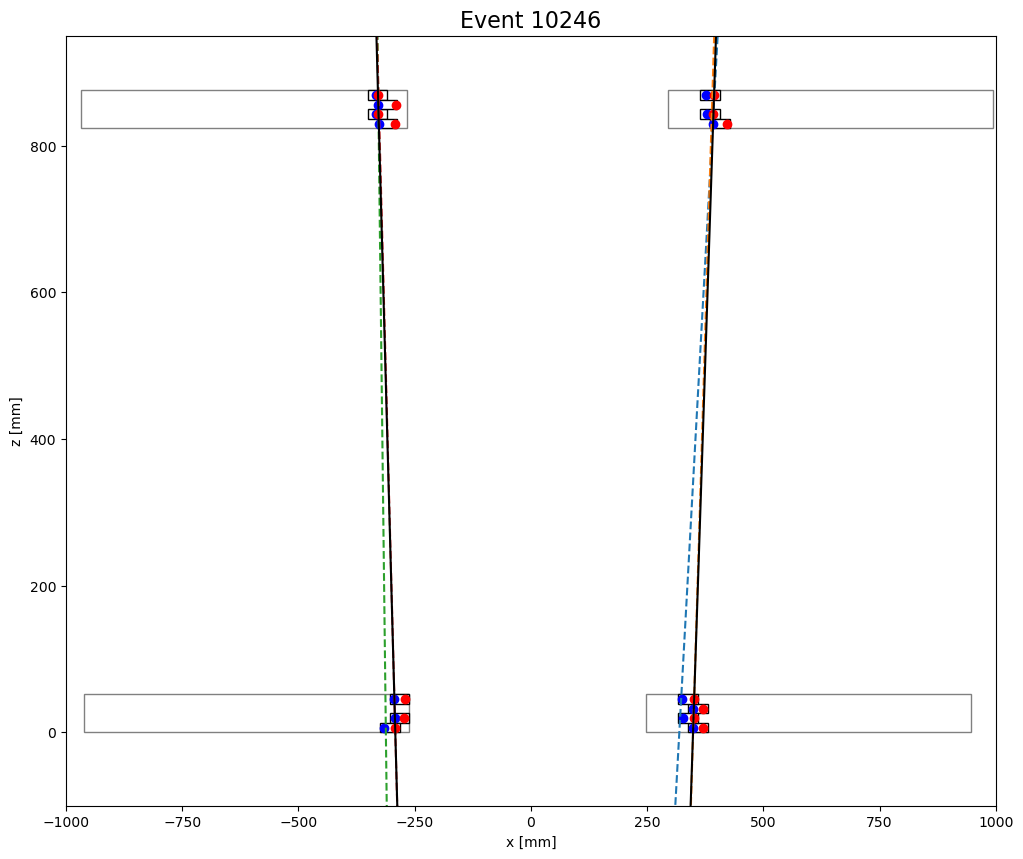

12
13538
    chamber  layer    xleft  xright   time      xrg     xlg     zg   center  \
0         0      1  397.300  400.70   32.2  596.900  593.50  869.0  595.200   
1         0      3  395.100  402.90   73.0  599.100  591.30  843.0  595.200   
2         0      4  406.600  433.40  249.7  587.600  560.80  830.0  574.200   
3         1      3  429.800  452.20  208.0  517.600  495.20   19.5  506.400   
4         1      2  410.800  429.20  171.3  536.600  518.20   32.5  527.400   
5         1      4  408.500  431.50  213.0  538.900  515.90    6.5  527.400   
6         1      1  427.600  454.40  249.7  519.800  493.00   45.5  506.400   
7         2      1   54.670   71.33  154.7 -322.070 -338.73  869.0 -330.400   
8         2      2   71.360   96.64  234.7 -338.760 -364.04  856.0 -351.400   
9         2      3   55.970   70.03  130.5 -323.370 -337.43  843.0 -330.400   
10        2      4   69.880   98.12  262.2 -337.280 -365.52  830.0 -351.400   
11        3      2   36.450   47.55  103.0 

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


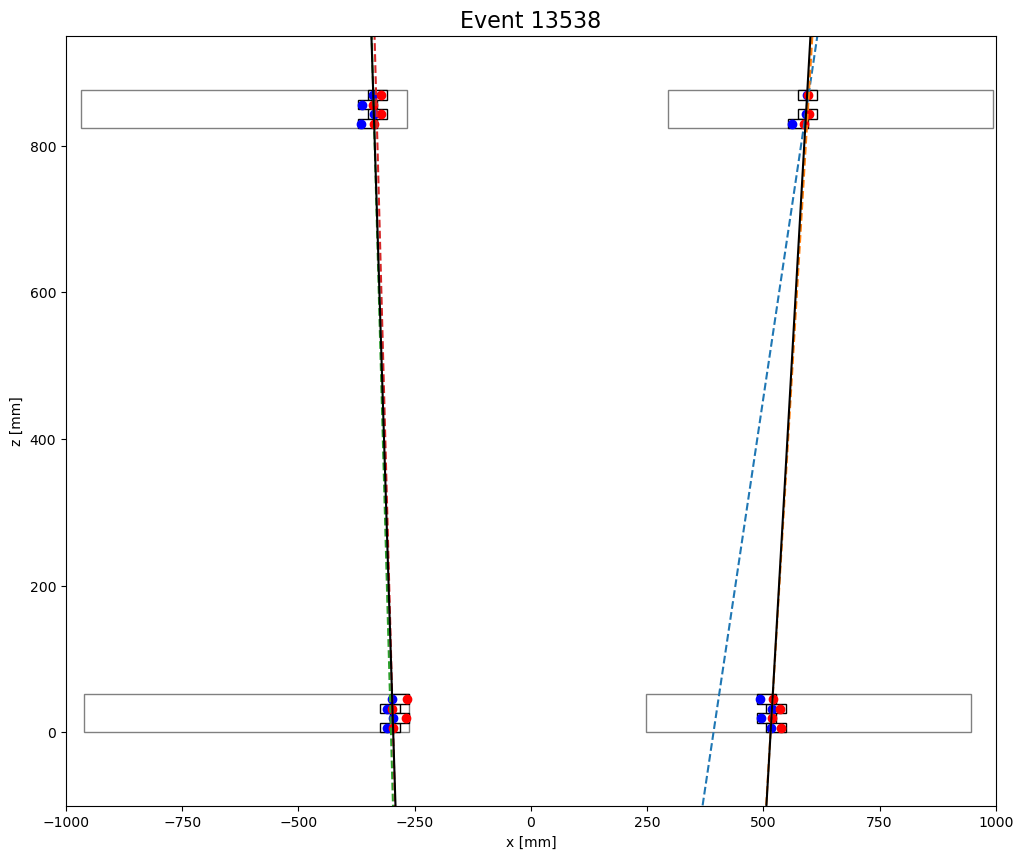

13
14367
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      3  565.80  568.20   22.2  428.40  426.00  843.0   427.2   
1         0      1  564.90  569.10   39.7  429.30  425.10  869.0   427.2   
2         0      2  525.60  566.40  378.0  468.60  427.80  856.0   448.2   
3         1      3  560.00  574.00  129.7  387.40  373.40   19.5   380.4   
4         1      1  558.80  575.20  152.2  388.60  372.20   45.5   380.4   
5         1      2  532.10  559.90  258.8  415.30  387.50   32.5   401.4   
6         1      4  531.00  561.00  278.8  416.40  386.40    6.5   401.4   
7         2      2   77.06   90.94  128.8 -344.46 -358.34  856.0  -351.4   
8         2      3   48.53   77.47  268.8 -315.93 -344.87  843.0  -330.4   
9         2      4   76.75   91.25  134.7 -344.15 -358.65  830.0  -351.4   
10        2      1   47.85   78.15  281.3 -315.25 -345.55  869.0  -330.4   
11        3      4   41.03   42.97   18.0 -302.53 -304.47    6.5  -303.5   
12 

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


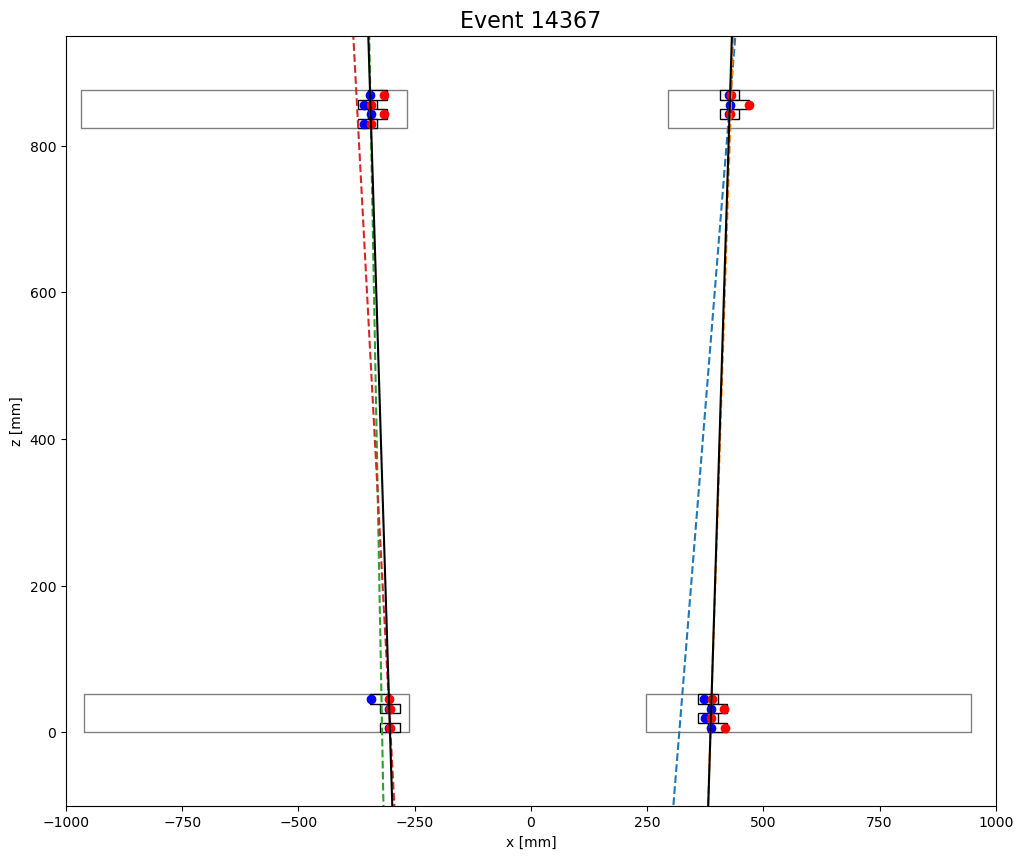

In [14]:
from matplotlib.patches import Rectangle
from scipy.stats import linregress

def event_plotter(event_number):
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    fig, ax=plt.subplots(figsize=(12,10))

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    ax.scatter(my_event['xlg'], my_event['zg'], color='blue')
    ax.scatter(my_event['xrg'], my_event['zg'], color='red')
    XRANGE=[-1000, 1000]
    YRANGE=[-100, 950]
    ax.set_xlim(XRANGE)
    ax.set_ylim(YRANGE)
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    def tracker_fitter(in_line_chambers):
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        xspace=np.linspace(*XRANGE, 1000)
        ax.plot(xspace, 1/resu.slope*xspace-resu.intercept/resu.slope, '--')
        ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
        ax.plot(xspace, 1/res.slope*xspace-res.intercept/res.slope, color='black')

        #ax.plot(xu,zu)
        #ax.plot(xd,zd)
    
    for i in range(0,len(calib_config),2):
        tracker_fitter(calib_config[i:i+2])


    plt.show()
    my_event


for k in range(min([50, len(impeccable_events)])):
    print(k)
    print(impeccable_events[k])
    print(cal1[impeccable_events[k]])
    event_plotter(impeccable_events[k])
#event_plotter(4)

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory

In [15]:
'''
event=cal1[1]
print(opt_track(event, 3))
'''

'\nevent=cal1[1]\nprint(opt_track(event, 3))\n'

/tmp/ipykernel_78084/616026479.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  single_chamber=event[event['chamber']==chamber][event['valid_hit']==True]


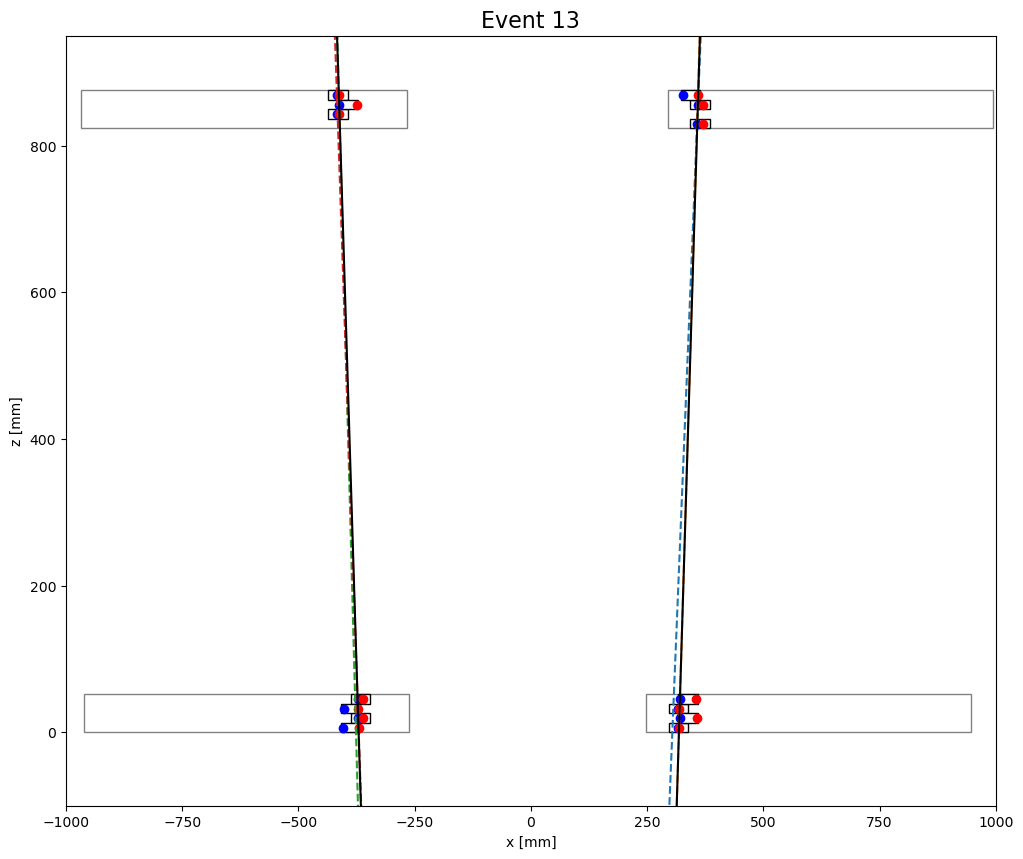

In [16]:
event_plotter(impeccable_events[0])